<a href="https://colab.research.google.com/github/colson1111/phillies/blob/main/initial_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Notebook

In this notebook, we will load the dataset of interest from Kaggle, read it in, and then answer some basic questions about it.  This will help to understand what we have available, and help come up with some more interesting questions later on.

We will conduct all EDA using _both_ the [pandas](https://pandas.pydata.org/) and [polars](https://pola.rs/) libraries.



Instructions to Access Kaggle Data from Colab: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/#h-bonus-tips

(You need to mount to Google Drive, and put kaggle.json in the drive)

In [2]:
!pip install kaggle

In [119]:
import pandas as pd
import numpy as np
import polars as pl

import plotly.express as px


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download mattop/philadelphia-phillies-batting-and-pitching-data

  0% 0.00/280k [00:00<?, ?B/s]
100% 280k/280k [00:00<00:00, 60.2MB/s]


In [7]:
!unzip ./philadelphia-phillies-batting-and-pitching-data.zip

Archive:  ./philadelphia-phillies-batting-and-pitching-data.zip
  inflating: PHI_batting.csv         
  inflating: PHI_pitching.csv        


In [109]:
# Read in with pandas
batting_pd = pd.read_csv('PHI_batting.csv', header=0)
pitching_pd = pd.read_csv('PHI_pitching.csv', header=0)

# Read in with polars
batting_pl = pl.read_csv('PHI_batting.csv')
pitching_pl = pl.read_csv('PHI_pitching.csv')

For EDA, I will start by just asking questions about the data.  This will help to understand exactly what we have available, and how to proceed with further more interesting questions.

**Question 1**:  What is year range of the batting and pitching datasets?

In [10]:
print("pandas")
print("Batting Year Range: ", batting_pd['Year'].min(), batting_pd['Year'].max())
print("Pitching Year Range: ", pitching_pd['Year'].min(), pitching_pd['Year'].max())
print("")

######################################3
print("polars")
print(batting_pl.select(pl.min('Year').alias('minYear'),
                  pl.max('Year').alias('maxYear'))
)

print(
pitching_pl.select(pl.min('Year').alias('minYear'),
                   pl.max('Year').alias('maxYear'))
)

pandas
Batting Year Range:  1883 2023
Pitching Year Range:  1883 2023

polars
shape: (1, 2)
┌─────────┬─────────┐
│ minYear ┆ maxYear │
│ ---     ┆ ---     │
│ i64     ┆ i64     │
╞═════════╪═════════╡
│ 1883    ┆ 2023    │
└─────────┴─────────┘
shape: (1, 2)
┌─────────┬─────────┐
│ minYear ┆ maxYear │
│ ---     ┆ ---     │
│ i64     ┆ i64     │
╞═════════╪═════════╡
│ 1883    ┆ 2023    │
└─────────┴─────────┘


**Question 2**:  How many total batters?  How many total pitchers? (Disregard cases where players have the same name)

In [63]:
print('pandas')
print('Total Batters: ', batting_pd[['Name']].nunique()[0])
print('Total Pitchers: ', pitching_pd[['Name']].nunique()[0])
print('')

######################################3
print('polars')
print('Total Batters: ', batting_pl.select('Name').unique().shape[0])
print('Total Pitchers: ', pitching_pl.select('Name').unique().shape[0])

pandas
Total Batters:  2169
Total Pitchers:  1074

polars
Total Batters:  2169
Total Pitchers:  1074


**Question 3**:  What were the average hits per batter in the 1970s? (Total number of hits / Total number of unique batters)

In [65]:
print('pandas')
aggregate = (batting_pd[batting_pd['Year'].between(1970, 1979, inclusive='both')]
 .agg({'Name': lambda x: x.nunique(), 'Hits': np.sum})
 )

hits_per_player = aggregate['Hits'] / aggregate['Name']

print(f'Hits per Player (1970s): {hits_per_player:.2f}')
print('')

######################################3
print('polars')
aggregate = (
    batting_pl.filter(pl.col('Year').is_between(1970, 1979))
    .select(pl.col('Name').n_unique(),
            pl.col('Hits').sum())
)

hits_per_player = aggregate['Hits'] / aggregate['Name']

print(f'Hits per Player (1970s): {hits_per_player[0]:.2f}')

pandas
Hits per Player (1970s): 99.01

polars
Hits per Player (1970s): 99.01


**Question 4**:  What were the strikeout totals, innings pitched, and K/9 for each decade?

In [133]:
print('pandas')
pitching_pd['Decade'] = pitching_pd['Year'] // 10 * 10

aggregate = (
    pitching_pd[['Decade', 'Innings_Pitched', 'Strikeouts']]
    .groupby('Decade')
    .sum()
    .reset_index()
)

aggregate['K per 9'] = (aggregate['Strikeouts'] / aggregate['Innings_Pitched']) * 9

aggregate

pandas


,Decade,Innings_Pitched,Strikeouts,K per 9
0,1880,7315.2,2979,3.665108
1,1890,12186.3,3344,2.469659
2,1900,13075.9,4721,3.249413
3,1910,13491.8,5865,3.912376
4,1920,13534.8,3729,2.479608
5,1930,13491.4,4496,2.999244
6,1940,13656.9,4920,3.242317
7,1950,13771.0,6818,4.455886
8,1960,14335.7,9257,5.811575
9,1970,14438.9,8894,5.543774


In [131]:
px.line(aggregate,
        x = 'Decade',
        y = ['K per 9']
)

In [114]:
print('polars')
pitching_pl = pitching_pl.with_columns( (pl.col('Year') // 10 * 10).alias('Decade'))

aggregate = (
    pitching_pl
    .groupby('Decade')
    .agg(pl.col('Innings_Pitched').sum().alias('IP'),
         pl.col('Strikeouts').sum().alias('K'),
         (pl.col('Strikeouts').sum() / pl.col('Innings_Pitched').sum() * 9).alias('K per 9'))
    .sort('Decade')
)

polars


In [121]:
px.line(x=aggregate["Decade"], y=aggregate["K per 9"])

In [138]:
batting_pd.columns

Index(['Rank', 'Year', 'Position', 'Name', 'Age', 'Games', 'Plate_Appearances',
       'At_Bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs',
       'Runs_Batted_In', 'Stolen_Bases', 'Caught_Stealing', 'Base_On_Balls',
       'Strikeouts', 'Batting_Average', 'On_Base_Percentage',
       'Slugging_Percentage', 'On_Base_Plus_Slugging_Percentage',
       'On_Base_Plus_Slugging_Percentage_Plus', 'Total_Bases',
       'Double_Plays_Grounded_Into', 'Times_Hit_By_Pitch', 'Sacrifice_Hits',
       'Sacrifice_Flies', 'Intentional_Bases_on_Balls', 'Dominant_Hand',
       'Switch_Hitter'],
      dtype='object')

**Question 5**: Generate a line plot that shows strikout/walk rate by handedness over time, as well as the percentage of pitchers in the year that were left-handed.

In [213]:
pitching_pd.columns

Index(['Rank', 'Year', 'Position', 'Name', 'Age', 'Wins', 'Losses',
       'Winning_Percentage', 'Earned_Run_Average', 'Games_Played',
       'Games_Started', 'Games_Finished', 'Complete_Games', 'Shutouts',
       'Saves', 'Innings_Pitched', 'Hits_Allowed', 'Runs_Allowed',
       'Earned_Runs', 'Home_Runs_Allowed', 'Walks_Allowed',
       'Intentional_Walks_Allowed', 'Strikeouts', 'Hit_By_Pitch', 'Balks',
       'Wild_Pitches', 'Batters_Faced', 'Adjusted_Earned_Run_Average',
       'Fielding_Independent_Pitching', 'Walks_Hits_Per_Inning_Pitched',
       'Hits_Per_Nine_Innings', 'Home_Runs_Per_Nine_Innings',
       'Walks_Per_Nine_Innings', 'Strikeouts_Per_Nine_Innings',
       'Strikeout_Walk_Ratio', 'Dominant_Hand', 'Switch_Hitter', 'Decade'],
      dtype='object')

In [220]:
pitching_pd['Decade'] = pitching_pd['Year'] // 10 * 10

pitching_grp = (
    pitching_pd[['Decade', 'Innings_Pitched', 'Strikeouts', 'Walks_Allowed', 'Dominant_Hand']]
    .groupby(['Decade', 'Dominant_Hand'])
    .agg({'Strikeouts': np.sum, 'Walks_Allowed': np.sum, 'Innings_Pitched': np.sum})
    .reset_index()
)

pitching_grp['K/Walk'] = pitching_grp['Strikeouts'] / pitching_grp['Walks_Allowed']

pitching_pivot = pitching_grp.pivot(index='Decade', columns='Dominant_Hand', values=['K/Walk', 'Innings_Pitched']).reset_index()

pitching_pivot.columns = pitching_pivot.columns.droplevel()
pitching_pivot.columns = ['Decade', 'Left', 'Right', 'Innings Left', 'Innings Right']

pitching_pivot['Lefty Innings Pct.'] = (
    pitching_pivot['Innings Left'] / (pitching_pivot['Innings Left'] + pitching_pivot['Innings Right'])
)

pitching_pivot = pitching_pivot.drop(['Innings Left', 'Innings Right'], axis=1)

In [221]:
pitching_pivot

,Decade,Left,Right,Lefty Innings Pct.
0,1880,1.255220,1.793966,0.186529
1,1890,0.851090,0.720600,0.159031
2,1900,1.386943,1.153731,0.136174
3,1910,1.317585,1.349903,0.179894
4,1920,0.686996,0.773831,0.198451
5,1930,0.908734,0.889387,0.189083
6,1940,0.947443,0.919016,0.249815
7,1950,1.502703,1.516937,0.218045
8,1960,1.989051,1.904929,0.271692
9,1970,1.838035,1.612625,0.433025


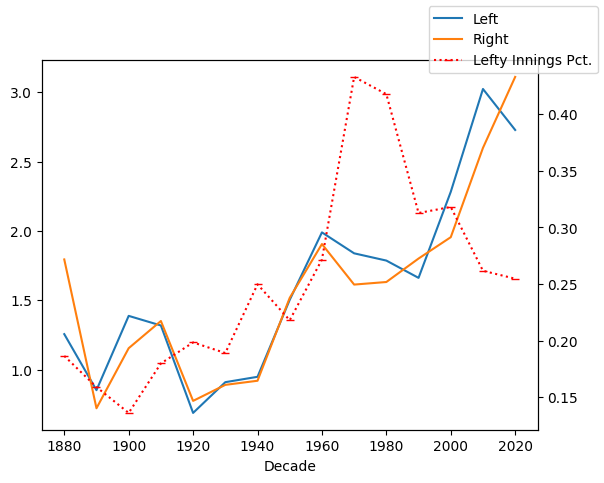

In [223]:
# plot the pivoted dataframe; if the column names aren't colors, remove color=df.columns
ax = pitching_pivot.plot(x="Decade", y="Left", legend=False)
pitching_pivot.plot(x="Decade", y="Right", ax=ax, legend=False)
ax2 = ax.twinx()
pitching_pivot.plot(x="Decade", y="Lefty Innings Pct.", linestyle=':', marker='_', ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()